![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de una bicicleta durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [dicccionario de datos](https://www.kaggle.com/c/bike-sharing-demand/data).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [43]:
# Importación de librerías
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingClassifier
from math import sqrt
from sklearn.metrics import f1_score, accuracy_score

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)
# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour
# Visualización
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables hour y workingday, escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('workingday').total.mean()

workingday
0    188.506621
1    193.011873
Name: total, dtype: float64

In [5]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [6]:
bikes[['workingday', 'total']].groupby('workingday').describe()

total                                                        
             count        mean         std  min   25%    50%    75%    max
workingday                                                                
0           3474.0  188.506621  173.724015  1.0  44.0  128.0  304.0  783.0
1           7412.0  193.011873  184.513659  1.0  41.0  151.0  277.0  977.0

In [7]:
bikes[['hour', 'total']].groupby(['hour']).describe()

total                                                            
      count        mean         std   min     25%    50%     75%    max
hour                                                                   
0     455.0   55.138462   43.620012   2.0   24.00   41.0   74.50  283.0
1     454.0   33.859031   34.112105   1.0   11.00   19.0   46.00  168.0
2     448.0   22.899554   26.110267   1.0    5.00   11.0   32.00  119.0
3     433.0   11.757506   12.666442   1.0    3.00    6.0   15.00   66.0
4     442.0    6.407240    4.217633   1.0    3.00    6.0    9.00   28.0
5     452.0   19.767699   12.784293   1.0    8.00   19.0   29.00   57.0
6     455.0   76.259341   54.745333   1.0   24.50   75.0  118.00  213.0
7     455.0  213.116484  159.207044   1.0   63.00  208.0  334.00  596.0
8     455.0  362.769231  231.723065   8.0  133.50  392.0  563.50  839.0
9     455.0  221.780220   92.099209  14.0  161.00  217.0  294.50  414.0
10    455.0  175.092308  101.807629  17.0  106.00  149.0  218.50  539.0
11    455.0  210.674725  127.444294  10.0  123.00  183.0  265.50  647.0
12    456.0  256.508772  143.881880   3.0  157.00  234.5  332.00  757.0
13    456.0  257.787281  149.167185  11.0  154.00  226.5  329.00  729.0
14    456.0  243.442982  147.563199  12.0  144.00  212.0  311.25  730.0
15    456.0  254.298246  144.235670   7.0  154.00  232.0  331.00  724.0
16    456.0  316.372807  145.664786  11.0  211.75  309.5  421.00  783.0
17    456.0  468.765351  223.775485  15.0  277.00  480.5  608.50  970.0
18    456.0  430.859649  219.908138  23.0  240.75  422.5  564.00  977.0
19    456.0  315.278509  156.641732  11.0  190.00  312.5  416.00  743.0
20    456.0  228.517544  116.411565  11.0  136.75  224.0  302.00  551.0
21    456.0  173.370614   87.629319   6.0  103.50  171.5  230.00  584.0
22    456.0  133.576754   69.844495   9.0   80.00  129.0  175.00  502.0
23    456.0   89.508772   51.638004   4.0   52.75   80.0  123.00  256.0

### Inferencias sobre el comportamiento de las dos variables (Hour y workingday).


**workingday:** Esta variable nos indica si el día no es fin de semana o no es festivo, es decir, día de trabajo. Podemos ver que en promedio por hora en un día de trabajo es de 193 alquileres de bicicletas, ligeramente superior cuando no es día de trabajo (188.5).

Cuando no es día de trabajo el 75% es menor o igual a 304 alquileres por hora, más alto que cuando si es... con 277 alquileres. Sin embargo, el pico de alquileres se registra en un día de trabajo con un número máximo de 977.

Hasta el momento logro inferir que la variable workingday si puede llegar a tener una influencia sobre el número total de alquileres, de todas formas se debe combinar con otras variables para revisar mejor como logra influir, es probable que la hora en la que se realiza y el tipo de día afecte de manera diferente ya que el comportamiento de las personas puede llegar a diferir cuando es un fin de semana o no.



**hour:** Esta variable es muy importante porque se espera que en horas de la madrugada el alquiler promedio por hora de bicicletas no sea muy alta y en horas de mayor afluencia de las personas en las calles el número aumente como puede ser en horas de la tarde.

Y efectivamente nos damos cuenta que los alquileres disminuyen considerablemente alrededor de las 9pm hasta 6am para luego ir aumentando.

Los mayores números de alquileres se registran entre 5pm y 6pm logrando el pico anteriormente mencionado de 977. Así mismo, a estas horas se puede observar que el 50% de los alquileres por hora son mayores a 422-480.



### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica de las rentas promedio por hora cuando la variable "workingday" es igual a 0 e igual a 1, respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

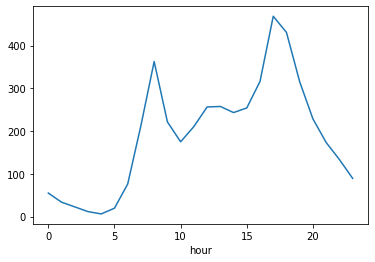

In [8]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

#### Análisis Gráfica 2.1
Analizamos la gráfica del promedio por hora de alquileres sin tener en cuenta si es día de trabajo o no. Observamos que el promedio disminuye considerablemente a altas horas de la noche y continua así durante las horas de la madrugada. A partir de las 5 de la manana los alquileres empiezan a mostrar una tendencia alcista alcanzando un pico aproximado a 362 para luego descender a las 10am. Lentamente, la tendencia empieza a subir hasta alcanzar otro pico a las 6pm de 977 alquileres para luego descender en la noche como anteriormente se había descrito.

<AxesSubplot:xlabel='hour'>

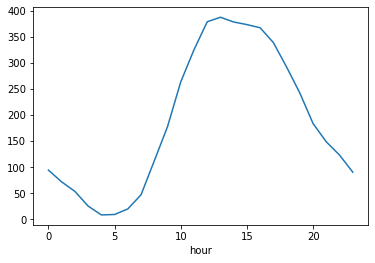

In [9]:
# Celda 2.2 - "workingday"=0 escriba su código y hallazgos 
bikes[bikes['workingday'] == 0].groupby('hour').total.mean().plot()

#### Análisis Gráfica 2.2

En esta gráfica tenemos en cuenta solamente cuando no es día de trabajo sino cuando es fin de semana o feriado. Analizamos un comportamiento diferente del total de alquileres por hora con respecto a la gráfica 2.1, aunque en horas de la noche y la madrugada los número disminuyen, podemos ver que no se generan dos picos pronunciados, sino que tenemos una subida de alquileres estable hasta alrededor las 4pm para luego descender lentamente.


<AxesSubplot:xlabel='hour'>

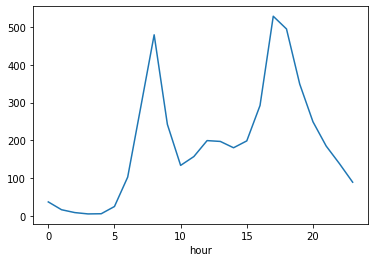

In [10]:
# Celda 2.3 - "workingday"=1 escriba su código y hallazgos 
bikes[bikes['workingday'] == 1].groupby('hour').total.mean().plot()

#### Análisis Gráfica 2.3

Finalmente, esta gráfica podemos observar los dos picos del total promedio de alquileres por hora observado en la gráfica 2.1. Estos dos picos se dan en horas en que las personas entra a trabajar (6am-8am) y cuando las personas salen de trabajar (5pm - 6pm).

En conclusíon podemos a tráves de estas gráficas ver como el patrón de comportamiento de los alquileres promedio por hora cambia si es o no un día de trabajo.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "hour" y "workingday" como las únicas variables predictoras. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [11]:
# Celda 3

y = bikes['total']
X = bikes[['workingday', 'hour']]

lin_reg = LinearRegression()
lin_reg.fit(X, y)


print("Intercept: \n", lin_reg.intercept_)
print("Coefficients: \n", 'workingday:', lin_reg.coef_[0], '\n', 'hour:', lin_reg.coef_[1])



Intercept: 
 67.70595026191619
Coefficients: 
 workingday: 4.072486272904358 
 hour: 10.492062822893725


In [12]:
#RMSE
rmse_lin_reg = sqrt(mean_squared_error(y, lin_reg.predict(X))) 
rmse_lin_reg

165.95558216733295

#### Interpretación Coeficientes

**workingday:** Cuando es un día de trabajo se espera que el promedio por hora del número de alquileres total se incremente en 4.07 personas en promedio, teniendo fijo la variable hour.

**hour:** Se espera que a medida que aumente la hora el promedio por hora del número de alquileres total se incremente en 10.49 personas en promedio, teniendo fijo la variable workingday. 


#### Limitación

Al haber observado el comportamiento de las variables pudimos observar que la relación no es lineal, de ahi la limitación de un modelo como la regresión lineal, al tener picos como los que vimos antes claramente las variables influyen de una forma no lineal, este tipo de comportamiento no es capturado por la regresión realizada. Lo deseable es realizar un modelo que pueda capturar ese comportamiento como lo puede ser un arból de decisión.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "workingday". El árbol debe tener al menos 6 nodos finales.

In [13]:
# Celda 4
#X = bikes[['workingday', 'hour']].reset_index(drop=True)
#y = bikes['total'].reset_index(drop=True)

In [14]:
# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [15]:
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [16]:
# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [17]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [18]:
# Aplicación de la función tree_grow
tree_grow(X, y, level=0, min_gain=0.001, max_depth=1, num_pct=10)

{'y_pred': 1,
 'y_prob': 191.53903379867745,
 'level': 0,
 'split': [1, 8.0],
 'n_samples': 10886,
 'gain': 18268.811823533004,
 'sl': {'y_pred': 1,
  'y_prob': 55.40711902113459,
  'level': 1,
  'split': -1,
  'n_samples': 3594,
  'gain': 7207.700659959655},
 'sr': {'y_pred': 1,
  'y_prob': 258.6007677543186,
  'level': 1,
  'split': -1,
  'n_samples': 7292,
  'gain': 7392.920792160614}}

In [19]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "hour" y "workingday" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [20]:
# Celda 5

# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 15)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
rmse_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    clf = DecisionTreeRegressor(max_depth=depth, random_state=1)
    rmse_scores.append(cross_val_score(clf, X, y, cv=10, scoring='neg_root_mean_squared_error').mean())

Text(0, 0.5, 'RMSE')

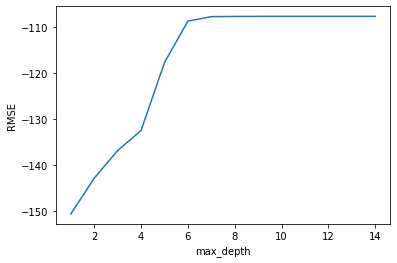

In [21]:
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, rmse_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE')

In [22]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(rmse_scores, max_depth_range))[::-1][0]

(-107.57576561312104, 14)

In [23]:
# max_depth=7 utilizamos 7 debido a que utilizando un número mayor la ganancia es marginal 
dtr = DecisionTreeRegressor(max_depth=7, random_state=1)
dtr.fit(X, y)

rmse_tree = sqrt(mean_squared_error(y, dtr.predict(X))) 
rmse_tree

106.51534478360098

In [24]:
# RMSE Regresión lineal punto 3
rmse_lin_reg

165.95558216733295

Utilizando como métrica de desempeno RMSE, comparamos que el mejor modelo es el arbol de decisión frente a la regresión lineal ya que pudimos obtener un menor RMSE de 165.95 a 106.51

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la populridad esta dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el sigueinte enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [25]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [26]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [27]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

#### Árbol de Decisión

Text(0, 0.5, 'Accuracy')

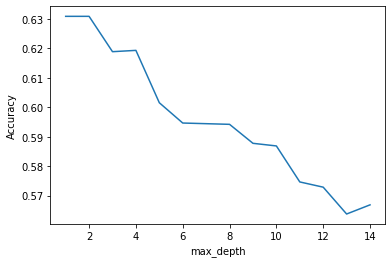

In [28]:
# Celda 6
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 15)

# Lista para guardar los valores del Accuracy para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())


# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [29]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.6308888888888888, 2)

In [30]:
# max_depth=2 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeClassifier(max_depth=2, random_state=1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('F1 Score: %.4f' % f1_score(y_test, y_pred))

Accuracy: 0.6453
F1 Score: 0.6449


#### Regresión Logística

In [49]:
clfRegLog= LogisticRegression(random_state=0,max_iter=10000)
clfRegLog.fit(X_train,y_train)

prediccionesRegLog=clfRegLog.predict(X_test)

print('Accuracy: %.4f' % accuracy_score(y_test, prediccionesRegLog))
print('F1 Score: %.4f' % f1_score(y_test, prediccionesRegLog))


Accuracy: 0.6213
F1 Score: 0.6056


Comparamos los modelos de Árbol de decisión y Regresión Logística con Accuracy y F1 Score:

**Árbol de Decisión**
Accuracy: 0.6453
F1 Score: 0.6449

**Regresión Logística**
Accuracy: 0.6213
F1 Score: 0.6056


El de mejor desempeno es Árbol de Decisión de acuerdo a ambos indicadores

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth = None\
-100 árboles de decisión donde max_depth = 2\
-100 regresiones logísticas

Evalúe los modelos utilizando las métricas de Accuracy y F1-Score.

In [63]:
# 100 árboles de decisión donde max_depth = None

clf = BaggingClassifier(DecisionTreeClassifier(max_depth = None),
                            n_jobs=-1,
                            max_samples=300,
                            n_estimators=100,
                            bootstrap=True, 
                            oob_score=True, 
                            random_state=1)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

clf1_f1_score_may=f1_score(y_pred, y_test)
clf1_accuracy_score_may=accuracy_score(y_pred, y_test)

In [64]:
# 100 árboles de decisión donde max_depth = 2

clf = BaggingClassifier(DecisionTreeClassifier(max_depth = 2),
                            n_jobs=-1,
                            max_samples=300,
                            n_estimators=100,
                            bootstrap=True, 
                            oob_score=True, 
                            random_state=1)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

clf2_f1_score_may=f1_score(y_pred, y_test)
clf2_accuracy_score_may=accuracy_score(y_pred, y_test)

In [65]:
# 100 regresiones logísticas

clf = BaggingClassifier(LogisticRegression(max_iter=10000),
                            n_jobs=-1,
                            max_samples=300,
                            n_estimators=100,
                            bootstrap=True, 
                            oob_score=True, 
                            random_state=1)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

clf3_f1_score_may=f1_score(y_pred, y_test)
clf3_accuracy_score_may=accuracy_score(y_pred, y_test)


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [66]:
# 100 árboles de decisión donde max_depth = None

clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth = None),
                            n_jobs=-1,
                            max_samples=300,
                            n_estimators=100,
                            bootstrap=True, 
                            oob_score=True, 
                            random_state=1)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

clf1_f1_score_pond=f1_score(y_pred, y_test)
clf1_accuracy_score_pond=accuracy_score(y_pred, y_test)

In [67]:
# 100 árboles de decisión donde max_depth = 2
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth = 2),
                            n_jobs=-1,
                            max_samples=300,
                            n_estimators=100,
                            bootstrap=True, 
                            oob_score=True, 
                            random_state=1)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

clf2_f1_score_pond=f1_score(y_pred, y_test)
clf2_accuracy_score_pond=accuracy_score(y_pred, y_test)

In [68]:
# 100 regresiones logísticas
clf = BaggingClassifier(base_estimator=LogisticRegression(max_iter=10000),
                            n_jobs=-1,
                            max_samples=300,
                            n_estimators=100,
                            bootstrap=True, 
                            oob_score=True, 
                            random_state=1)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

clf3_f1_score_pond=f1_score(y_pred, y_test)
clf3_accuracy_score_pond=accuracy_score(y_pred, y_test)

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

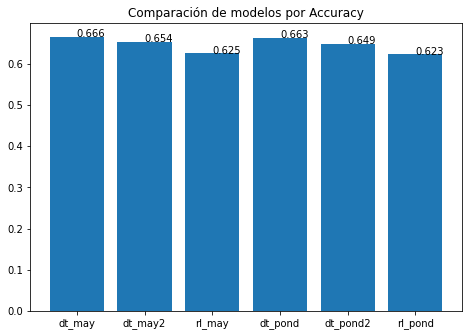

In [72]:
# Celda 9

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos por Accuracy")
ejeX = ['dt_may', 'dt_may2','rl_may', 'dt_pond', 'dt_pond2', 'rl_pond']
ejeY = [round(clf1_accuracy_score_may, 3), round(clf2_accuracy_score_may, 3), round(clf3_accuracy_score_may, 3),
        round(clf1_accuracy_score_pond, 3), round(clf2_accuracy_score_pond, 3), round(clf3_accuracy_score_pond, 3)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()

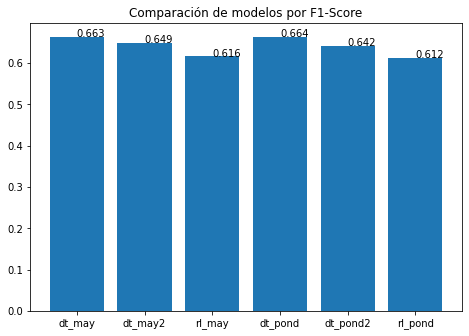

In [74]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos por F1-Score")
ejeX = ['dt_may', 'dt_may2','rl_may', 'dt_pond', 'dt_pond2', 'rl_pond']
ejeY = [round(clf1_f1_score_may, 3), round(clf2_f1_score_may, 3), round(clf3_f1_score_may, 3),
        round(clf1_f1_score_pond, 3), round(clf2_f1_score_pond, 3), round(clf3_f1_score_pond, 3)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()

In [82]:
df.groupby('Popular').Popular.count()

Popular
0    3000
1    3000
Name: Popular, dtype: int64

**Análisis de Resultado**

Teniendo en cuenta el accuracy el mejor modelo es árbol de decisión con votación mayoritaria con un 0.666 de acurracy.

Entre las ventajas de hacer un modelo como árbol de decisión es su capacidad de capturar patrones no lineales en los datos, es así que en general estos modelos son mejores que el de regresión logística para este problema lo que tambien se evidencia en los indicadores tanto accuracy como f1 score. 

Otra de las ventajas de usar árboles de decisión es que son modelos con alta variabilidad lo que es muy bueno para la metodología bagging, ya que uno de los objetivos es reducir la varianza. Mientras que el modelo de regresión logística como tal es de poca varianza.

Para este caso el desempeno medido por accuracy es muy bueno para comparar, debido a que los datos estan perfectamente balanceados.